In [5]:
# import libraries

In [6]:
# investigate data

In [12]:
import sqlite3
import pandas as pd
from IPython.display import display


def to_csv():
    
    # connect to the db
    db_path = r'..\data\northWind.sqlite'
    try:
        db = sqlite3.connect(db_path)
        cursor = db.cursor()
    except:
        print("Failed to connect to SQLite database {"+ db_path + "}")
        return
    print("Connected to SQLite database {"+ db_path + "}")
    print()
    
    # list all the table names in the db
    this_query = "SELECT name FROM sqlite_master WHERE type='table';"
    try:
        cursor.execute(this_query)
        tables = cursor.fetchall()
    except:
        print("Failed to execute SQLite query {"+ this_query + "}")
        return
    table_names = [t[0] for t in tables]
    
    for table_name in table_names:
        
        # List the column names in the current table
        this_query = """PRAGMA table_info('%s');""" % table_name
        try:
            cursor.execute(this_query)
            cols = cursor.fetchall()
        except:
            print("failed to execute query {" + this_query + "}")
            return
        col_names = [c[1] for c in cols]
        print("Number of columns in table {"+ table_name + "} = " + str(len(col_names)))
       
        # List the rows in the current table
        this_query = """SELECT * from '%s';""" % table_name
        try:
            cursor.execute(this_query)
            records = cursor.fetchall()
        except:
            print("failed to execute query {" + this_query + "}")
            return
        data = [list(r) for r in records]
        print("Number of rows in table {"+ table_name + "} = " + str(len(data)))
        
        try:
            table = pd.DataFrame(data, columns=col_names)
        except:
            print("failed to create a dataframe for table {" + table_name + "}")
            return
        
        csvPath = "..\\data\\" + table_name + ".csv"
        wrote_csv = False
        try:
            table.to_csv(csvPath, index_label='index')
            wrote_csv = True
        except:
            pass
        if wrote_csv:
            print("wrote table {" + table_name + "} to file {" + csvPath + "}.")
            print()
        else:
            return "failed to write table {" + table_name + "} to file {" + csvPath + "}"
                
    cursor.close()
    db.close()
    return

to_csv()

Connected to SQLite database {..\data\northWind.sqlite}

Number of columns in table {Employee} = 18
Number of rows in table {Employee} = 9
wrote table {Employee} to file {..\data\Employee.csv}.

Number of columns in table {Category} = 3
Number of rows in table {Category} = 8
wrote table {Category} to file {..\data\Category.csv}.

Number of columns in table {Customer} = 11
Number of rows in table {Customer} = 91
wrote table {Customer} to file {..\data\Customer.csv}.

Number of columns in table {Shipper} = 3
Number of rows in table {Shipper} = 3
wrote table {Shipper} to file {..\data\Shipper.csv}.

Number of columns in table {Supplier} = 12
Number of rows in table {Supplier} = 29
wrote table {Supplier} to file {..\data\Supplier.csv}.

Number of columns in table {Order} = 14
Number of rows in table {Order} = 830
wrote table {Order} to file {..\data\Order.csv}.

Number of columns in table {Product} = 10
Number of rows in table {Product} = 77
wrote table {Product} to file {..\data\Product.c

In [14]:
from datetime import datetime
import pandas as pd
from IPython.display import display

# import csv file that contains northern hemisphere season start dates for 2000-2021
# the csv file was quasi-scraped from https://www.timeanddate.com/calendar/seasons.html?year=2000
table_Seasons = "Seasons"
seasons_list = ["Spring", "Summer", "Fall", "Winter"]
df_Seasons = pd.read_csv("..\\data\\" + table_Seasons + ".csv").set_index("Year")
for s in seasons_list:
    df_Seasons[s + '_Start'] = pd.to_datetime(df_Seasons[s + '_Start'], utc=True)
display(df_Seasons)


def date_to_season(dt):
    dtz = pd.to_datetime(dt, utc=True)
    iYear = dtz.year
    spring_start = df_Seasons["Spring_Start"][iYear]
    summer_start = df_Seasons["Summer_Start"][iYear]
    fall_start = df_Seasons["Fall_Start"][iYear]
    winter_start = df_Seasons["Winter_Start"][iYear]
    if dtz < spring_start:
        return "Winter"
    if dtz < summer_start:
        return "Spring"
    if dtz < fall_start:
        return "Summer"
    if dtz < winter_start:
        return "Fall"
    return "Winter"


table_Order = "Order"
df_Order = pd.read_csv("..\\data\\" + table_Order + ".csv").set_index("index")
df_Order['OrderDate'] = pd.to_datetime(df_Order['OrderDate'])
OID_raw = df_Order["Id"].to_list()
OID_all = sorted(OID_raw)
OID_salesPerLine = [list() for k in OID_all]
OID_to_salesPerLine = dict(zip(OID_all, OID_salesPerLine))

table_OrderDetail = "OrderDetail"
df_OrderDetail = pd.read_csv("..\\data\\" + table_OrderDetail + ".csv").set_index("index")

line_indices = list(df_OrderDetail.index.values)
for i in line_indices:
    this_OID = df_OrderDetail['OrderId'][i]
    this_UnitPrice = df_OrderDetail['UnitPrice'][i]
    this_Quantity = df_OrderDetail['Quantity'][i]
    this_Discount = df_OrderDetail['Discount'][i]
    this_salesPerLine = round(this_UnitPrice * this_Quantity * (1 - this_Discount), 2)
    OID_to_salesPerLine[this_OID].append(this_salesPerLine)
OID_salesThisOrder = [round(sum(OID_to_salesPerLine[k]),2) for k in OID_all]
OID_to_salesThisOrder = dict(zip(OID_all, OID_salesThisOrder))

df_Order['Season'] = [date_to_season(d) for d in df_Order['OrderDate']]
df_Order['Sales'] = [OID_to_salesThisOrder[k] for k in OID_raw]
df_Order['Sales_by_LineItem'] = [OID_to_salesPerLine[k] for k in OID_raw]

display(df_Order)
print()
df_Order.info()
print()

table_name = 'Order_with_Sales_by_Season'
csvPath = "..\\data\\" + table_name + ".csv"
wrote_csv = False
try:
    df_Order.to_csv(csvPath, index_label='index')
    wrote_csv = True
except:
    pass
if wrote_csv:
    print("wrote table {" + table_name + "} to file {" + csvPath + "}.")
    print()
else:
    print("failed to write table {" + table_name + "} to file {" + csvPath + "}")


,Spring_Start,Summer_Start,Fall_Start,Winter_Start
Year,,,,
2000,2000-03-20 07:35:00+00:00,2000-06-21 01:47:00+00:00,2000-09-22 17:27:00+00:00,2000-12-21 13:37:00+00:00
2001,2001-03-20 13:30:00+00:00,2001-06-21 07:37:00+00:00,2001-09-22 23:04:00+00:00,2001-12-21 19:21:00+00:00
2002,2002-03-20 19:16:00+00:00,2002-06-21 13:24:00+00:00,2002-09-23 04:55:00+00:00,2002-12-22 01:14:00+00:00
2003,2003-03-21 00:59:00+00:00,2003-06-21 19:10:00+00:00,2003-09-23 10:46:00+00:00,2003-12-22 07:03:00+00:00
2004,2004-03-20 06:48:00+00:00,2004-06-21 00:56:00+00:00,2004-09-22 16:29:00+00:00,2004-12-21 12:41:00+00:00
2005,2005-03-20 12:33:00+00:00,2005-06-21 06:46:00+00:00,2005-09-22 22:23:00+00:00,2005-12-21 18:34:00+00:00
2006,2006-03-20 18:25:00+00:00,2006-06-21 12:25:00+00:00,2006-09-23 04:03:00+00:00,2006-12-22 00:22:00+00:00
2007,2007-03-21 00:07:00+00:00,2007-06-21 18:06:00+00:00,2007-09-23 09:51:00+00:00,2007-12-22 06:07:00+00:00
2008,2008-03-20 05:48:00+00:00,2008-06-20 23:59:00+00:00,2008-09-22 15:44:00+00:00,2008-12-21 12:03:00+00:00


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Season,Sales,Sales_by_LineItem
index,,,,,,,,,,,,,,,,,
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,Summer,440.00,"[168.0, 98.0, 174.0]"
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,Summer,1863.40,"[167.4, 1696.0]"
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,Summer,1552.60,"[77.0, 1261.4, 214.2]"
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,Summer,654.06,"[95.76, 222.3, 336.0]"
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,Summer,3597.90,"[2462.4, 47.5, 1088.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,11073,PERIC,2,2014-05-05,2014-06-02,NaN,2,24.95,Pericles Comidas clásicas,Calle Dr. Jorge Cash 321,México D.F.,Central America,05033,Mexico,Spring,300.00,"[210.0, 90.0]"
826,11074,SIMOB,7,2014-05-06,2014-06-03,NaN,2,18.44,Simons bistro,Vinbæltet 34,Kobenhavn,Northern Europe,1734,Denmark,Spring,232.08,[232.08]
827,11075,RICSU,8,2014-05-06,2014-06-03,NaN,2,6.19,Richter Supermarkt,Starenweg 5,Genève,Western Europe,1204,Switzerland,Spring,498.10,"[161.5, 306.0, 30.6]"



<class 'pandas.core.frame.DataFrame'>
Int64Index: 830 entries, 0 to 829
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Id                 830 non-null    int64         
 1   CustomerId         830 non-null    object        
 2   EmployeeId         830 non-null    int64         
 3   OrderDate          830 non-null    datetime64[ns]
 4   RequiredDate       830 non-null    object        
 5   ShippedDate        809 non-null    object        
 6   ShipVia            830 non-null    int64         
 7   Freight            830 non-null    float64       
 8   ShipName           830 non-null    object        
 9   ShipAddress        830 non-null    object        
 10  ShipCity           830 non-null    object        
 11  ShipRegion         830 non-null    object        
 12  ShipPostalCode     811 non-null    object        
 13  ShipCountry        830 non-null    object        
 14  Season   

# Question 1: Is there a difference in quantity of products sold by discount rate? 

In [2]:
# obtain necessary data

## {Put test name here}
H0: 

HA:

In [4]:
# perform test

## Conclusion

## EffectSize/PowerAnalysis/Tukey Testing (if needed)

# Question 2: Is there a difference in number of orders and territory? 

In [2]:
# obtain necessary data

## {Put test name here}
H0: 

HA:

In [4]:
# perform test

## Conclusion

# Question 3: Is there a difference in [Sales per Order] between Summer and other seasons?

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,Season,Sales,Sales_by_LineItem
index,,,,,,,,,,,,,,,,,
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,Summer,440.00,"[168.0, 98.0, 174.0]"
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,Summer,1863.40,"[167.4, 1696.0]"
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,Summer,1552.60,"[77.0, 1261.4, 214.2]"
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,Summer,654.06,"[95.76, 222.3, 336.0]"
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,Summer,3597.90,"[2462.4, 47.5, 1088.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,11073,PERIC,2,2014-05-05,2014-06-02,NaN,2,24.95,Pericles Comidas clásicas,Calle Dr. Jorge Cash 321,México D.F.,Central America,05033,Mexico,Spring,300.00,"[210.0, 90.0]"
826,11074,SIMOB,7,2014-05-06,2014-06-03,NaN,2,18.44,Simons bistro,Vinbæltet 34,Kobenhavn,Northern Europe,1734,Denmark,Spring,232.08,[232.08]
827,11075,RICSU,8,2014-05-06,2014-06-03,NaN,2,6.19,Richter Supermarkt,Starenweg 5,Genève,Western Europe,1204,Switzerland,Spring,498.10,"[161.5, 306.0, 30.6]"



<class 'pandas.core.frame.DataFrame'>
Int64Index: 830 entries, 0 to 829
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Id                 830 non-null    int64         
 1   CustomerId         830 non-null    object        
 2   EmployeeId         830 non-null    int64         
 3   OrderDate          830 non-null    datetime64[ns]
 4   RequiredDate       830 non-null    object        
 5   ShippedDate        809 non-null    object        
 6   ShipVia            830 non-null    int64         
 7   Freight            830 non-null    float64       
 8   ShipName           830 non-null    object        
 9   ShipAddress        830 non-null    object        
 10  ShipCity           830 non-null    object        
 11  ShipRegion         830 non-null    object        
 12  ShipPostalCode     811 non-null    object        
 13  ShipCountry        830 non-null    object        
 14  Season   

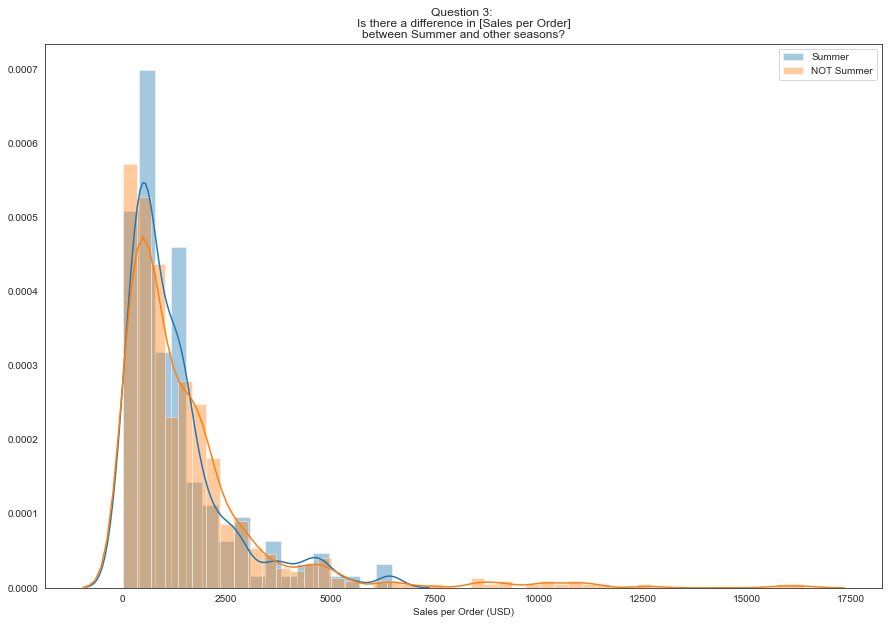

In [36]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import scipy.stats as scs
import numpy as np
import plotly.figure_factory as ff

sns.set_style("white")

def bootstrap(arr):
    return np.random.choice(arr, size=arr.shape, replace=True)


def generate_sample_mus(arr, num_samples=30):
    sample_mus = [] 
    for i in range(num_samples):
        sample = bootstrap(arr)
        mu = np.mean(sample)
        sample_mus.append(mu)
    return sample_mus


def test_for_normality(arr, confidence=0.95):
    t, p = scs.shapiro(arr)
    if p <= 1 - confidence:
        print("reject the null")
        return False
    print("fail to reject the null")
    return True

def cohens_d(arr1, arr2):
    narr1 = len(arr1)
    narr2 = len(arr2)
    dof = narr1 + narr2 - 2
    return (np.mean(arr1) - np.mean(arr2)) / np.sqrt(((narr1-1)*np.std(arr1, ddof=1) ** 2 + (narr2-1)*np.std(arr2, ddof=1) ** 2) / dof)

table_Order = 'Order_with_Sales_by_Season'
df_Order = pd.read_csv("..\\data\\" + table_Order + ".csv").set_index("index")
df_Order['OrderDate'] = pd.to_datetime(df_Order['OrderDate'])


display(df_Order)
print()
df_Order.info()
print()

sales_during_Summer = df_Order["Sales"].loc[df_Order['Season'] == 'Summer']
sales_NOT_during_Summer = df_Order["Sales"].loc[df_Order['Season'] != 'Summer']

print(sales_during_Summer)
print(sales_NOT_during_Summer)


fig, ax = plt.subplots(figsize=(15, 10))
sns.distplot(sales_during_Summer, label="Summer")
sns.distplot(sales_NOT_during_Summer, label="NOT Summer")
plt.title("Question 3: \nIs there a difference in [Sales per Order]\nbetween Summer and other seasons?")
plt.xlabel("Sales per Order (USD)")
plt.legend();


In [37]:
print(test_for_normality(sales_during_Summer), test_for_normality(sales_NOT_during_Summer))

reject the null
reject the null
False False


In [38]:
sample_quant_Summer = generate_sample_mus(sales_during_Summer)
sample_quant_notSummer = generate_sample_mus(sales_NOT_during_Summer)

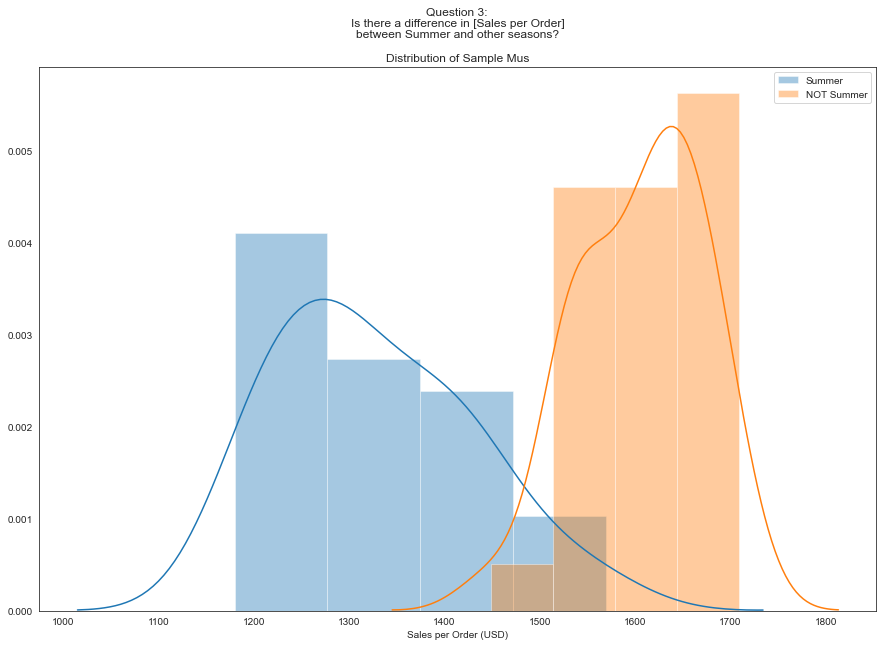

In [39]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.distplot(sample_quant_Summer, label="Summer")
sns.distplot(sample_quant_notSummer, label="NOT Summer")
plt.title("Question 3: \nIs there a difference in [Sales per Order]\n" + 
          "between Summer and other seasons?\n\n" +
          "Distribution of Sample Mus")
plt.xlabel("Sales per Order (USD)")
plt.legend();


In [40]:
hist_data = [sample_quant_Summer, sample_quant_notSummer]
group_labels = ['Summer','NotSummer']
fig = ff.create_distplot(hist_data, group_labels, bin_size = 10)
fig.show()

In [41]:
t, p = scs.ttest_ind(sample_quant_Summer, sample_quant_notSummer, equal_var=False)
p

4.750017138915001e-17

In [42]:
scs.f_oneway(sample_quant_Summer, sample_quant_notSummer)

F_onewayResult(statistic=160.30659489645814, pvalue=2.4507726566224298e-18)

In [43]:
effect_size = cohens_d(sample_quant_Summer, sample_quant_notSummer)
effect_size

-3.2691139971604812

## {Put test name here}
H0: 

HA:

In [4]:
# perform test

## Conclusion

## EffectSize/PowerAnalysis/Tukey Testing (if needed)